## Pendahuluan

Dokumen ini menyajikan analisis regresi menggunakan metode **Generalized Least Squares (GLS)**. Pendekatan ini merupakan proses "tuning" iteratif untuk membangun model yang dapat mengatasi **dua masalah asumsi sekaligus**: heteroskedastisitas dan autokorelasi.

Alih-alih menangani masalah secara terpisah, GLS secara bertahap menyetel parameter untuk varians dan korelasi sisaan, menghasilkan estimasi yang lebih efisien dan inferensi yang lebih valid, serupa dengan pendekatan yang digunakan oleh paket statistik canggih.

## Memuat Paket dan Data

### Memuat Paket Python

In [24]:
# Impor paket untuk manipulasi data
import pandas as pd
import numpy as np

# Impor paket untuk pemodelan statistik
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Impor paket untuk uji statistik
from scipy import stats
from scipy.linalg import toeplitz

# Impor paket untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur agar plot ditampilkan di dalam notebook
%matplotlib inline
sns.set_style('whitegrid')

### Mengimpor Data dari File Excel

In [25]:
# Ganti path file di bawah ini!
file_path = "C:/Users/user/OneDrive - untirta.ac.id/R Script/Github_Regresi_OLS/data_simulasi_gls.xlsx"
data_FGLS = pd.read_excel(file_path)

### Menampilkan Data yang diimpor

In [26]:
data_FGLS.head(6)

,y,x1,x2,x3,time
0,44.245264,1,63.957209,53.708923,1
1,35.033373,2,48.545686,37.719907,2
2,47.918691,3,50.852951,48.378023,3
3,59.391126,4,49.905935,60.880715,4
4,45.621889,5,66.817071,53.592014,5
5,76.923170,6,50.255130,60.671912,6


## Membangun Model OLS Awal (Untuk Diagnosis)
Kita memulai dengan OLS untuk mengidentifikasi dan mengkonfirmasi adanya pelanggaran asumsi.

In [27]:
# Membangun model OLS awal
model_ols_awal = smf.ols('y ~ x1 + x2 + x3', data=data_FGLS).fit()
residuals_ols = model_ols_awal.resid
exog_ols = model_ols_awal.model.exog

# Menampilkan ringkasan OLS awal
print(model_ols_awal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     7.929
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           8.86e-05
Time:                        06:31:36   Log-Likelihood:                -609.73
No. Observations:                 100   AIC:                             1227.
Df Residuals:                      96   BIC:                             1238.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8581     70.506      0.012      0.9

## Uji Asumsi Klasik pada Model OLS

#### Uji Normalitas (Shapiro-Wilk)

In [28]:
shapiro_test_ols = stats.shapiro(residuals_ols)
print(f"--- Uji Normalitas (Shapiro-Wilk) ---")
print(f"Statistik Uji: {shapiro_test_ols.statistic:.4f}, P-value: {shapiro_test_ols.pvalue:.4f}")

--- Uji Normalitas (Shapiro-Wilk) ---
Statistik Uji: 0.9831, P-value: 0.2304


#### Uji Homoskedastisitas (Breusch-Pagan)

In [29]:
bp_test_ols = het_breuschpagan(residuals_ols, exog_ols)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("--- Uji Homoskedastisitas (Breusch-Pagan) ---")
for label, value in zip(labels, bp_test_ols):
    print(f"{label}: {value:.4f}")

--- Uji Homoskedastisitas (Breusch-Pagan) ---
LM Statistic: 20.1846
LM-Test p-value: 0.0002
F-Statistic: 8.0925
F-Test p-value: 0.0001


#### Uji Autokorelasi (Durbin-Watson)

In [30]:
dw_stat = durbin_watson(residuals_ols)
print(f"--- Uji Autokorelasi (Durbin-Watson) ---")
print(f"Statistik D-W: {dw_stat:.4f}")

--- Uji Autokorelasi (Durbin-Watson) ---
Statistik D-W: 0.7408


#### Uji Multikolinearitas (VIF)

In [32]:
vif_data = pd.DataFrame()
vif_data["feature"] = model_ols_awal.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(exog_ols, i) for i in range(len(model_ols_awal.model.exog_names))]
print("--- Uji Multikolinearitas (VIF) ---")
print(vif_data[vif_data['feature'] != 'Intercept'])

--- Uji Multikolinearitas (VIF) ---
  feature       VIF
1      x1  1.007994
2      x2  1.002954
3      x3  1.010958


### Diagnosis Visual Autokorelasi

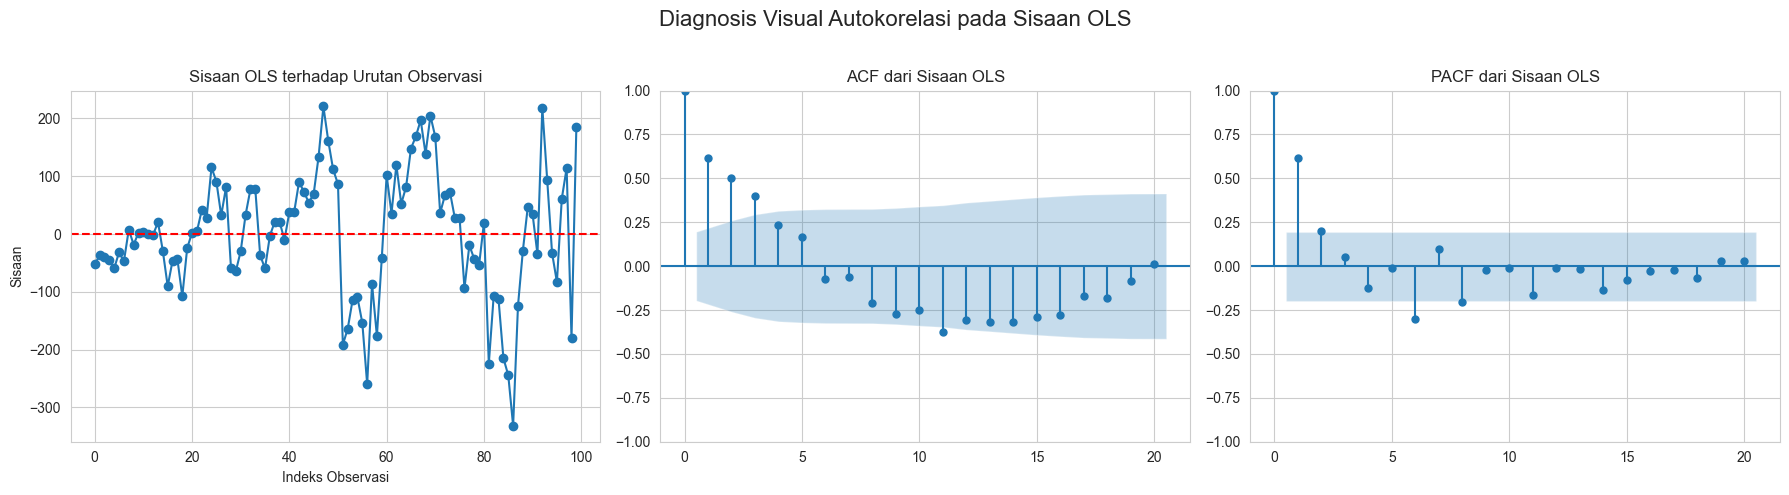

In [42]:
# Plot sisaan terhadap indeks/urutan
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Diagnosis Visual Autokorelasi pada Sisaan OLS', fontsize=16)

# Plot Sisaan vs. Urutan
axes[0].plot(residuals_ols.index, residuals_ols, marker='o', linestyle='-')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Sisaan OLS terhadap Urutan Observasi')
axes[0].set_xlabel('Indeks Observasi')
axes[0].set_ylabel('Sisaan')

# Plot ACF
plot_acf(residuals_ols, ax=axes[1], title='ACF dari Sisaan OLS')

# Plot PACF
plot_pacf(residuals_ols, ax=axes[2], title='PACF dari Sisaan OLS')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

*Interpretasi Diagnosis:* Hasil di atas mengkonfirmasi adanya heteroskedastisitas (p-value rendah) dan autokorelasi dengan struktur AR(1) (PACF terpotong setelah lag 1). Ini membenarkan perlunya proses tuning dengan FGLS.

## Pemodelan GLS dengan Struktur Korelasi AR(1)

Berdasarkan diagnosis, kita akan menggunakan model `GLSAR` (Generalized Least Squares with Autoregressive error) untuk memperbaiki model dengan menentukan orde AR sebesar 1.

In [50]:
# Pisahkan variabel dependen (y) dan independen (X)
y = data_FGLS['y']
X = data_FGLS[['x1', 'x2', 'x3']]
X = sm.add_constant(X)

# Model OLS awal
model_ols_awal = sm.OLS(y, X).fit()
residuals = model_ols_awal.resid

# Inisialisasi parameter
max_iter = 10
tolerance = 1e-6
rho_old = 0
nobs = len(y)

print("Memulai proses tuning FGLS iteratif...")

for i in range(max_iter):
    # --- Langkah A: Estimasi Struktur Varian (Heteroskedastisitas) ---
    # Modelkan varians menggunakan sisaan dari iterasi sebelumnya
    log_resid_sq = np.log(residuals**2)
    model_aux_var = sm.OLS(log_resid_sq, X).fit()
    weights = 1 / np.exp(model_aux_var.fittedvalues)

    # --- Langkah B: Estimasi Struktur Korelasi (Autokorelasi) ---
    # Jalankan WLS dengan bobot saat ini untuk mendapatkan sisaan yang lebih baik
    model_wls_iter = sm.WLS(y, X, weights=weights).fit()
    residuals_wls = model_wls_iter.resid
    # Gunakan sisaan WLS yang sudah bersih untuk mendapatkan estimasi rho yang akurat
    resid_t = residuals_wls[1:].reset_index(drop=True)
    resid_tm1 = residuals_wls[:-1].reset_index(drop=True)
    rho_new = sm.OLS(resid_t, resid_tm1).fit().params[0]
    
    print(f"Iterasi {i+1}: rho = {rho_new:.6f}")

    # --- Langkah C: Cek Konvergensi ---
    if np.abs(rho_new - rho_old) < tolerance:
        print(f"\nKonvergensi tercapai pada iterasi {i+1}.")
        break
    
    rho_old = rho_new
    
    # --- Langkah D: Dapatkan sisaan baru dari model GLS sementara untuk iterasi berikutnya ---
    rho_matrix_iter = toeplitz(rho_new ** np.arange(nobs))
    variance_matrix_iter = np.diag(1 / weights)
    sqrt_var_iter = np.sqrt(variance_matrix_iter)
    sigma_iter = sqrt_var_iter @ rho_matrix_iter @ sqrt_var_iter
    
    model_gls_iter = sm.GLS(y, X, sigma=sigma_iter).fit()
    residuals = model_gls_iter.resid
else:
    print("\nBatas maksimum iterasi tercapai.")

# Simpan parameter final yang sudah dituning
rho_final = rho_new
weights_final = weights



Memulai proses tuning FGLS iteratif...
Iterasi 1: rho = 0.664960
Iterasi 2: rho = 0.672466
Iterasi 3: rho = 0.661146
Iterasi 4: rho = 0.667662
Iterasi 5: rho = 0.660499
Iterasi 6: rho = 0.669348
Iterasi 7: rho = 0.664721
Iterasi 8: rho = 0.665796
Iterasi 9: rho = 0.665900
Iterasi 10: rho = 0.665839

Batas maksimum iterasi tercapai.


C:\Users\user\AppData\Local\Temp\ipykernel_8864\2431867351.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho_new = sm.OLS(resid_t, resid_tm1).fit().params[0]


## Pemodelan GLS Final dengan Parameter yang Sudah Dituning

Dengan `weights` dan `rho` yang sudah konvergen, kita membangun model GLS final. Kita akan secara manual membangun matriks kovarians sisaan (`sigma`) yang menggabungkan kedua struktur error ini, lalu memberikannya ke model `sm.GLS`.

In [51]:
# 1. Buat matriks korelasi AR(1) dari rho_final
rho_matrix = toeplitz(rho_final ** np.arange(nobs))

# 2. Buat matriks varians dari bobot final
variance_matrix = np.diag(1 / weights_final)

# 3. Gabungkan keduanya untuk membuat matriks kovarians sisaan (sigma)
sqrt_var = np.sqrt(variance_matrix)
sigma = sqrt_var @ rho_matrix @ sqrt_var

# 4. Bangun model GLS final dengan sigma yang sudah didefinisikan
model_gls_final = sm.GLS(y, X, sigma=sigma).fit()

# 5. Tampilkan ringkasan
print(f"--- Ringkasan Model GLS Final (Setelah Tuning FGLS Iteratif) ---")
print(f"Rho Final yang Digunakan: {rho_final:.6f}\n")
print(model_gls_final.summary())

--- Ringkasan Model GLS Final (Setelah Tuning FGLS Iteratif) ---
Rho Final yang Digunakan: 0.665839

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.325
Model:                            GLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     15.43
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           2.88e-08
Time:                        08:11:28   Log-Likelihood:                -554.25
No. Observations:                 100   AIC:                             1117.
Df Residuals:                      96   BIC:                             1127.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

## Evaluasi Kebaikan Model (Goodness-of-Fit)

In [54]:
# Ekstrak metrik evaluasi
loglik_gls = model_gls_final.llf
aic_gls = model_gls_final.aic
bic_gls = model_gls_final.bic

# Buat DataFrame untuk menampilkan hasil
evaluasi_data_gls = {
    'Metrik': ['Log-Likelihood', 'AIC', 'BIC'],
    'Nilai': [loglik_gls, aic_gls, bic_gls]
}
evaluasi_df_gls = pd.DataFrame(evaluasi_data_gls)

print("Metrik Kebaikan Model (Goodness-of-Fit) untuk GLS Final")
evaluasi_df_gls

Metrik Kebaikan Model (Goodness-of-Fit) untuk GLS Final


,Metrik,Nilai
0,Log-Likelihood,-554.254523
1,AIC,1116.509046
2,BIC,1126.929726
